# Datacube formats

A datacube is essentially a multi-dimensional array that enables the manipulation and analysis of complex datasets. In satellite imagery, datacubes are commonly used to create and work with time series data. For example, a datacube might contain a stack of *N* rasters, each with dimensions X × Y, where each raster represents the same spatial area at different dates. This structure allows for efficient comparison, temporal analysis, and trend detection over time. Datacubes can also handle other dimensions beyond time, such as spectral bands, enabling even more detailed analyses across wavelengths. They can store both raster and vector data. Visual example of a simple datacube:

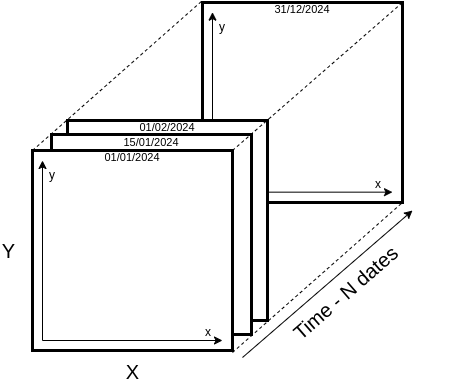

Datacubes also allow more complex structure, for example (source: xarray official documentation):

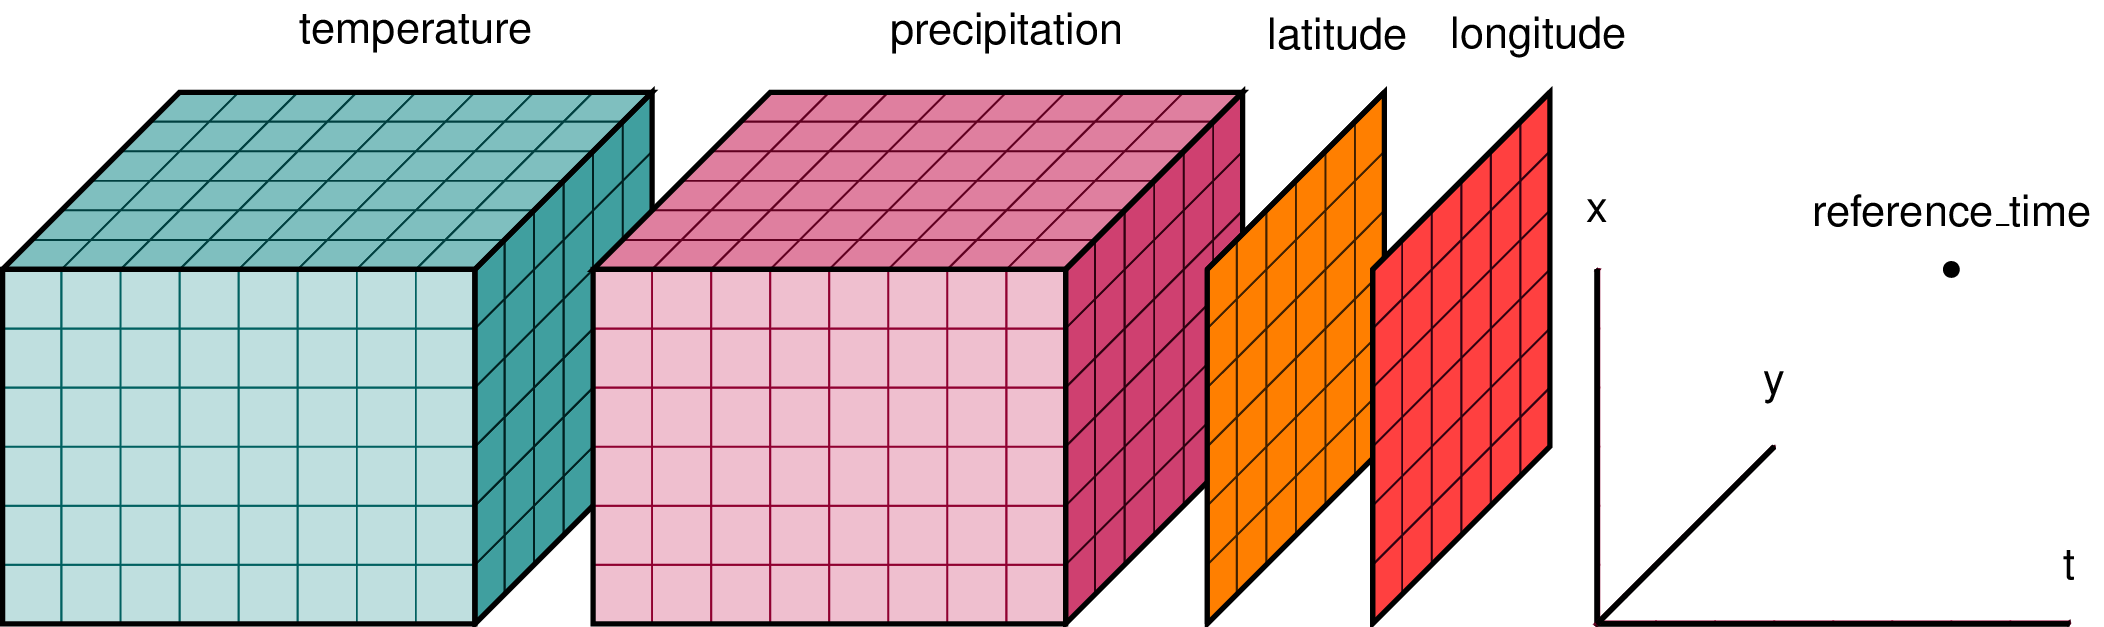

The following formats will be presented:

1) [hdf5](#HDF5-format)
2) [netcdf](#Netcdf)
3) [zarr](#Zarr)

In [1]:
# Generic notebook imports

import time

import numpy as np
import matplotlib.pyplot as plt
from utils import download_netcdf, generate_hdf5_file, get_file_size_in_mb, rescale_raster

REFERENCE_RASTER = "./sample_data/rasters/data/xt_SENTINEL2B_20180621-111349-432_L2A_T30TWT_D_V1-8_RVBPIR.tif"

## HDF5 format

First, we'll present the HDF5 (Hierarchical Data Format version 5) format (https://www.hdfgroup.org/solutions/hdf5/). This is a widely spread format, used for storing and managing complex datasets. It's hierarchical structure allows storing multiple datasets (which can contain sub-datasets and so on), with corresponding metadata (dataset name, attributes etc ...), making storage and data retrieval very efficient.

For this example, the test data will contain rasters (the same ones used in the [raster format tutorial](./raster_formats.ipynb)). However, you can find multiple sources of `.h5` files, which will generally require you to create an account (for example rainfall data from https://disc.gsfc.nasa.gov/).

In [2]:
hdf5_file = "./sample_data/data_cube/example.h5"  # change this path if needed
generate_hdf5_file(hdf5_file, REFERENCE_RASTER)  # generate a dataset with random data

HDF5 files are organized in groups and datasets. Groups can contain groups and datasets and datasets act like numpy arrays. This generated file contains one group with two datasets (one with 2D data, one with 3D data). To list the group(s) and datasets, use:

List of dataset(s) and group(s): ['data']
Data group's metadata: {'creation_date': '2024-11-25', 'project': 'Tutorial example project'}
List of datasets: ['data_2d', 'data_3d']
2d dataset's shape: (2080, 2410)
3d dataset's shape: (4, 2080, 2410)
3d dataset's metadata{'DIMENSION_LABELS': array(['time', 'latitude', 'longitude'], dtype=object), 'description': 'RGB bands from a raster'}
dataset's dimensions names['time', 'latitude', 'longitude']


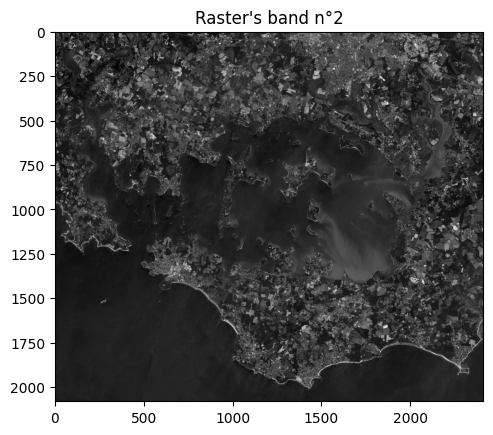

In [3]:
import h5py

with h5py.File(hdf5_file, 'r') as f:  # open the file
    print(f"List of dataset(s) and group(s): {list(f.keys())}")  # only one key: 'data' (a group)

    # 'data' group
    data_group = f["data"]
    print(f"Data group's metadata: {dict(data_group.attrs)}")
    print(f"List of datasets: {list(data_group.keys())}")  # two keys: ['data_2d', 'data_3d'] (both are datasets)
    
    # 'data_2d' dataset
    dataset_2d = data_group["data_2d"]
    print(f"2d dataset's shape: {dataset_2d.shape}")

    # 'data_3d' dataset
    start = time.time()
    dataset_3d = data_group["data_3d"]
    read_time = time.time() - start
    print(f"3d dataset's shape: {dataset_3d.shape}")
    print(f"3d dataset's metadata{dict(dataset_3d.attrs)}")  # dataset's metadata (dimensions, description)
    dims_3d_labels = [dim.label for dim in dataset_3d.dims]  # get a more readable list of dimensions' labels
    print(f"dataset's dimensions names{dims_3d_labels}")
    
    rescaled_data = rescale_raster(np.array(dataset_2d))
    n_band = 1
    plt.imshow(rescaled_data, cmap="gray")
    plt.title(f"Raster's band n°{n_band+1}")
    plt.show()

In [4]:
start = time.time()
with h5py.File(hdf5_file, 'r') as f:  # open the file
    dataset_3d = f["data"]["data_3d"]
    read_time = time.time() - start


print(f"Read time: {read_time:.5f} seconds")
print(f"File size: {get_file_size_in_mb(hdf5_file):.2f} MB")

Read time: 0.00162 seconds
File size: 100.26 MB


This file contains one 3-band raster and one 1-band raster. In tiff format, these rasters's size are respectively 80 and 20MB MB. The hdf5 file size is around 100 MB, so the file size is equivalent, but the time needed to open and load the data is much smaller. 

## Netcdf

Now, let's take a look at an NETcdf file. First, we download an example file, containing precipitation data (other files can be found [here](https://www.unidata.ucar.edu/software/netcdf/examples/files.html)), open it and print the object:

In [21]:
import xarray as xr

netcf_file = download_netcdf("./sample_data/data_cube/")
nc_dataset = xr.open_dataset(netcf_file, engine="netcdf4")
nc_dataset

<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 360, lon: 720, time: 1356)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 11kB 1901-01-01 1901-02-01 ... 2013-12-01
Data variables:
    precip   (time, lat, lon) float32 1GB ...
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_downl...
    Conventions:      CF 1.0
    References:       http://www.esrl.noaa.gov/psd/data/gridded/data.gpcc.html
    history:          Created 01/2016 based on V7 data obtained via ftp
    title:            GPCC Full Data Reanalysis Version 7 0.5x0.5 Monthly Total
    dataset_title:    Global Precipitation Climatology Centre (GPCC)

This is another 3D datafile (longitude, latitude, time), containing only one data type (precipitation). More complex meteorological files could contain wind speeds, temperature etc... Here, we list all the available data variables: 

In [6]:
nc_dataset.data_vars

Data variables:
    precip   (time, lat, lon) float32 1GB ...

And the corresponding dataset:

In [7]:
nc_dataset.precip

<xarray.DataArray 'precip' (time: 1356, lat: 360, lon: 720)> Size: 1GB
[351475200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 11kB 1901-01-01 1901-02-01 ... 2013-12-01
Attributes:
    units:         mm
    var_desc:      Precipitation
    level_desc:    Surface
    parent_stat:   Observations
    long_name:     GPCC Monthly total of precipitation
    valid_range:   [   0. 8000.]
    actual_range:  [   0.   4530.85]
    dataset:       GPCC Precipitation 0.5degree V7 Full Reanalysis
    statistic:     Total
    level:         Surface

We can now plot the precipitation for a given date using `hvplot` using slicing (see [xarray slicing documentation](https://docs.xarray.dev/en/stable/user-guide/indexing.html) for more info). Change the `date` value to plot the data for a given date: if it's not available, using `method="nearest"` will use the closest available date:

In [22]:
import hvplot.xarray
import cartopy.crs as ccrs

precipitation_data = nc_dataset.precip
date = '2013-12-02'
date_to_plot = precipitation_data.sel(time=date, method="nearest")  # the nearest selects the nearest date 
vmin = date_to_plot.quantile(0.05)  # adapt the ranges of the values for a better visualisation
vmax = date_to_plot.quantile(0.99)
image = date_to_plot.hvplot.image(
    x="lon", y="lat", projection=ccrs.PlateCarree(),  # geospatial parameters
    cmap="viridis", colorbar=True, clim=(vmin, vmax),  # colors parameters
    width=500, height=400)  # size of the graph

image.opts(tools=['pan', 'wheel_zoom', 'hover'], show_grid=True)  # additional parameters for the plot

image

:Image   [lon,lat]   (GPCC Monthly total of precipitation)

`hvplot` can also be used to create interactive animations using the `panel` library. See the [official hvplot documentation](https://hvplot.holoviz.org/) for more details.

In [9]:
import panel as pn

# slider widget
time_slider = pn.widgets.Player(name='time', start=0, end=len(precipitation_data.time) - 1, loop_policy='loop', interval=100)

# function to update the plot, based on the created widget
@pn.depends(time=time_slider)
def update_image(time):
    date_to_plot = precipitation_data[time]
    vmin, vmax = date_to_plot.quantile([0.05, 0.99])  # adjusted min/max values ranges
    return date_to_plot.hvplot.image(
        x="lon", y="lat", projection=ccrs.PlateCarree(),
        cmap="viridis", colorbar=True, clim=(vmin, vmax),
        width=500, height=400
    )

pn.Column(update_image, time_slider).servable()

Column
    [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Player(end=1355, interval=100, loop_policy='loop', name='time')

It is also possible to open this file with qgis: open a new project, load the netcdf file (this can take a while and QGIS may stop responding for a moment). Three layers are added:

- A tabular layer
- A mesh layer
- A raster layer

Keep only the mesh layer. You can also add a map background (google earth, open street maps...). So far, your project should look like this:

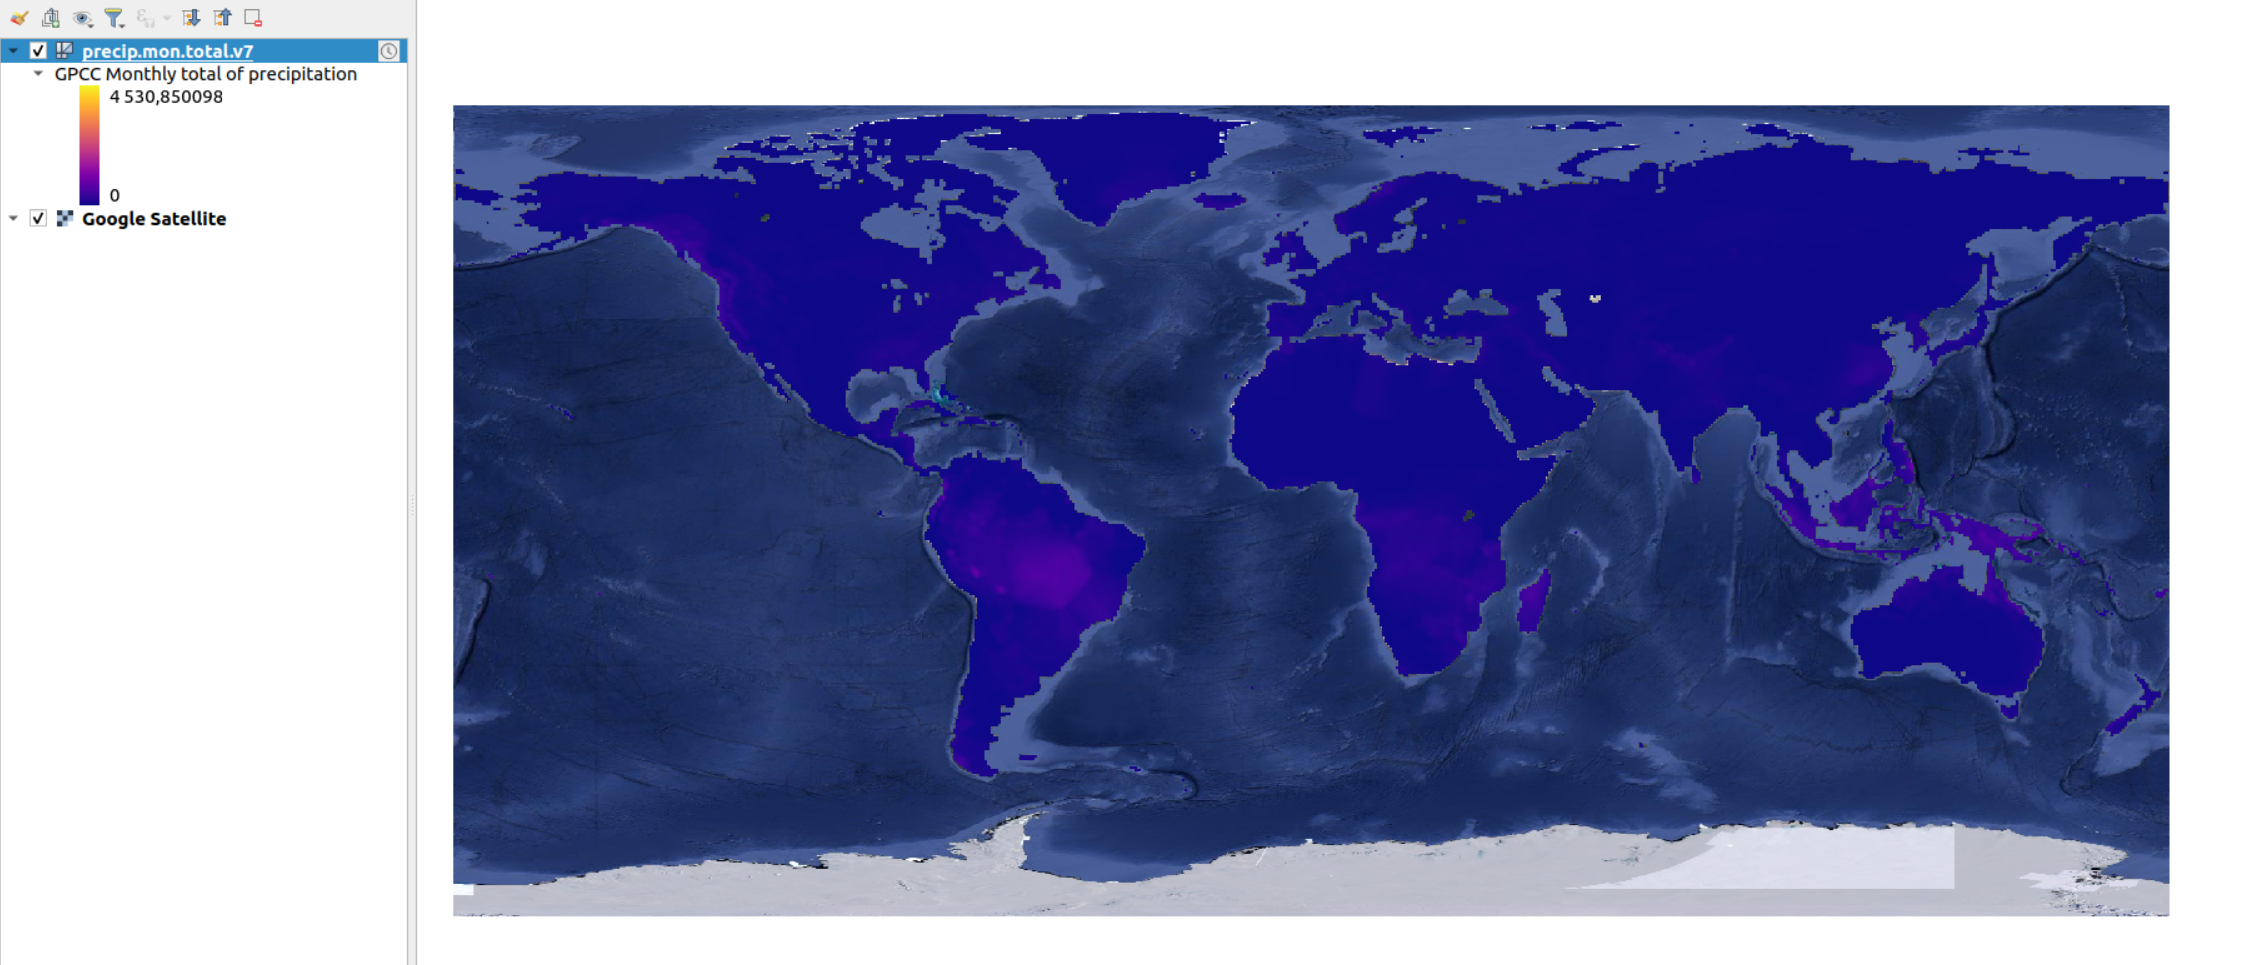

In the mesh layer options, you can adapt the colorbar values range for a better visualization. Finally, open the temporal controller (see details [here](https://www.qgistutorials.com/en/docs/3/animating_time_series.html)) to display an animation. The raster layer also has temporal information, where each bands corresponds to one date.

## Zarr

Zarr is a modern, cloud optimized format. It stores data as compressed chunks, in different files, making storage and access highly efficient. Let's create a .zarr containing 10 dates arrays of size 1000x1000. This could represent 10 satellite images (10 different observations) i.e. a time series:

In [10]:
import numpy as np
import zarr

sample_file = "./sample_data/data_cube/example.zarr"
n_time, n_lat, n_lon = 10, 1000, 1000

data = np.random.rand(n_time, n_lat, n_lon)

zarr_file = zarr.open(sample_file, mode='w')
zarr_file.create_dataset("data", data=data)

z1 = zarr.load(sample_file)
data = z1["data"]
print(data.shape)

(10, 1000, 1000)


A new directory was created, with the data. We can check the number and size of the chunks using:

In [11]:
zarr_file = zarr.open(sample_file, mode='r')
data = zarr_file["data"]
data.info

Name               : /data
Type               : zarr.core.Array
Data type          : float64
Shape              : (10, 1000, 1000)
Chunk shape        : (2, 250, 250)
Order              : C
Read-only          : True
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 80000000 (76.3M)
No. bytes stored   : 70046241 (66.8M)
Storage ratio      : 1.1
Chunks initialized : 80/80

80 chunks of size (2, 250, 250) were created, meaning each chunk contains a quarter of two images. However, with satellite images, it is generally more efficient to access one complete image at a time. In this setup, opening a single image could require loading 2 to 4 different chunks, depending on whether any chunk holds two quarters of the same image. To streamline this, we could adjust the chunk size to store only one full image per chunk, with each chunk shaped as (1, 1000, 1000). This configuration can be specified in the `create_dataset` method:

In [12]:
sample_file = "./sample_data/data_cube/example2.zarr"
zarr_file = zarr.open(sample_file, mode='w')
zarr_file.create_dataset("data", data=data, chunks=(1, n_lat, n_lon))
data = zarr_file["data"]
data.info

Name               : /data
Type               : zarr.core.Array
Data type          : float64
Shape              : (10, 1000, 1000)
Chunk shape        : (1, 1000, 1000)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 80000000 (76.3M)
No. bytes stored   : 70068763 (66.8M)
Storage ratio      : 1.1
Chunks initialized : 10/10

Only 10 chunks are then created, as expected. If images are too big to be loaded entirely, it would be possible to chunk the images themselves. For example, splitting each image in 4 smaller images, creating 4 times more chunks using `chunks=(1, 250, 250)`. 

The [official zarr library tutorial]( https://zarr.readthedocs.io/en/stable/tutorial.html#reading-and-writing-data) presents many more concepts and optimization methods. For example, using `write_empty_chunks=False` will not write empty chunks, improving both speed and storage size.

The `xarray` library can also be used to manipulate .zarr files:

In [13]:
import xarray as xr
import numpy as np

sample_file = "./sample_data/data_cube/example_from_xarray.zarr"

data = xr.DataArray(np.random.rand(n_time, n_lat, n_lon),
                    dims=["time", "lat", "lon"],
                    coords={"time": range(n_time),
                            "lat": range(n_lat),
                            "lon": range(n_lon)})

data.to_dataset(name="data").to_zarr(sample_file, mode="w")


ds = xr.open_zarr(sample_file)
ds

<xarray.Dataset> Size: 80MB
Dimensions:  (time: 10, lat: 1000, lon: 1000)
Coordinates:
  * lat      (lat) int64 8kB 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * lon      (lon) int64 8kB 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * time     (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    data     (time, lat, lon) float64 80MB dask.array<chunksize=(2, 250, 250), meta=np.ndarray>

As an example use case, we can load a COG file (see the [raster formats tutorial](./raster_formats.ipynb)) and write it to a zarr, using `xarray`.

In [14]:
input_cog_path = "./sample_data/rasters/data/xt_SENTINEL2B_20180621-111349-432_L2A_T30TWT_D_V1-8_RVBPIR_cog.tif"
output_zarr_path = "./sample_data/data_cube/example_from_cog.zarr"

with xr.open_dataset(input_cog_path, engine="rasterio") as xds:
    xds.to_zarr(output_zarr_path, mode="w")

zarr_file = zarr.open(output_zarr_path, mode='r')
data = zarr_file["band_data"]
data.info

Name               : /band_data
Type               : zarr.core.Array
Data type          : float32
Shape              : (4, 2080, 2410)
Chunk shape        : (1, 520, 603)
Order              : C
Read-only          : True
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 80204800 (76.5M)
No. bytes stored   : 35688486 (34.0M)
Storage ratio      : 2.2
Chunks initialized : 64/64

### Accessing data from a cloud


Zarr being a cloud-optimized format, this section will show of to deal with cloud-hosted zarr files. As an example, the GoogleCloud public dataset (containing meteorological data) will be used. Here is how to open a cloud file given its 

In [15]:
import xarray as xr

ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr', 
    chunks={'time': 48},
    consolidated=True,
)
ds

<xarray.Dataset> Size: 31TB
Dimensions:              (time: 374016, values: 542080)
Coordinates:
    depthBelowLandLayer  float64 8B ...
    entireAtmosphere     float64 8B ...
    latitude             (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 8B ...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
  * time                 (time) datetime64[ns] 3MB 1979-01-01 ... 2021-08-31T...
    valid_time           (time) datetime64[ns] 3MB dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    d2m                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    hcc                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl1                (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl2                (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl3                (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    ...                   ...
    tsn                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u10                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u100                 (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v10                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v100                 (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    z                    (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    GRIB_edition:              1
    GRIB_subCentre:            0
    history:                   2022-09-23T18:56 GRIB to CDM+CF via cfgrib-0.9...
    institution:               European Centre for Medium-Range Weather Forec...
    pangeo-forge:inputs_hash:  5f4378143e9f42402424280b63472752da3aa79179b53b...
    pangeo-forge:recipe_hash:  0c3415923e347ce9dac9dc5c6d209525f4d45d799bd25b...
    pangeo-forge:version:      0.9.1

In [16]:
print(f"dataset size: {ds.nbytes/(1024 ** 4):.1f}TiB")

dataset size: 28.0TiB


Opening a file from a cloud is suite similar to opening it from a local file. The main difference is data access: each operation on the dataset will query data from the server. If the connection to the cloud is limited, it is important to use coherent chunk sizes and slices to make sure the access is optimized.

### ZCollection

Managing `.zarr` files can be tricky, because of their nature. `ZCollection` (https://zcollection.readthedocs.io) is a python library that helps storing `.zarr` files in a more meaningful way by re-arranging them by collections: either by dates or by variables. This allows for a more human-readable data organization and optimizes data reading. It makes it easier to process data over only a specific time period or over some specific data and prevents loading useless data for a given process.

### Kerchunk

Another useful cloud-optimized library for dealing with datacubes is [kerchunk](https://fsspec.github.io/kerchunk/). It can be used to open files in formats discussed in previous tutorials (zarr, netcdf, (geo)tiff ...). Kerchunk generates a JSON file that contains an index and metadata for all the relevant files, enabling efficient access and management of large datasets.

In order to keep this notebook concise, no tutorial will be provided, but you can easily find detailed examples and documentation on the [Kerchunk website](https://fsspec.github.io/kerchunk/).

## Formats comparison

In order to compare the 3 presented formats, we need an equivalent data array. In order to keep the code simple, a function was written [here](./utils.py) which creates a random numpy array, write it to 3 files (HDF5, netCDF and zarr) and read them right after. This allows us to measure the read and write times as well as file sizes. Here are the results:

In [17]:
from utils import compare_datacube_formats

comparison_directory = "./sample_data/data_cube/formats_comparison"
compare_datacube_formats(comparison_directory, (100, 1000, 1000))

Write times:
	h5: 0.481 seconds
	nc: 0.509 seconds
	zarr: 0.728 seconds
Read times:
	h5: 0.330 seconds
	nc: 0.004 seconds
	zarr: 1.081 seconds
File sizes:
	h5: 800.002 MB
	nc: 800.008 MB
	zarr: 701.546 MB


## Conclusion

Datacubes are a powerful way to store data, even of different data types. Many different tools can be used to visualize and amnipulate such files depending on your needs. Each format has specific technicalities and details to optimize read/write time and file sizes, so carefully choosing a format for a given use is important. It is also important to choose the right tool: for example, for a quick visualization of data, `matplotlib` can be sufficient and may be easier to use. But for a more interactive plot, while keeping a simple code, `hvplot` can be a better solution, especially if used with `xarray`.